1. Don't alter training and testing stimuli artifically
2. Give feedback during testing

In [1]:
import math
import wave
import struct
import pdb
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.stats
import random

In [2]:
"""
Variable audio will contain a long list of samples (i.e. floating point numbers describing the
waveform).  If you were working with a very long sound you'd want to stream this to
disk instead of buffering it all in memory list this.  But most sounds will fit in 
memory.   
"""

def append_silence(audio, sample_rate, duration_milliseconds=225):
    """
    Adding silence is easy - we add zeros to the end of our array
    """
    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)): 
        audio.append(0.0)
    return audio

def append_sinewave(audio, sample_rate, 
                    freq, 
                    duration_milliseconds=400, 
                    volume=1.0):
    """
    The sine wave generated here is the standard beep.  If you want something
    more aggresive you could try a square or saw tooth waveform.   Though there
    are some rather complicated issues with making high quality square and
    sawtooth waves... which we won't address here
    """ 
    num_samples = duration_milliseconds * (sample_rate / 1000.0)
    signal = []
    
    for x in range(int(num_samples)):
        signal.append(volume * math.sin(2 * math.pi * freq * (x/sample_rate)))
    signal = envelopeKCW(signal, 20, sample_rate) 
    for x_signal in range(len(signal)):
        audio.append(signal[x_signal])
    return audio

def envelopeKCW(signal,rampDur,sample_rate):
    """
    This function tries to remove the transients in the signal by enveloping the first and last period.
    Ramp duration is defined by rampDur in **ms** envelope(signal,rampDuration,samplerate)
    """
    samples = int(np.round((rampDur/1000)*sample_rate))
    x = np.arange(-np.pi,0,np.pi/samples)
    y = np.arange(0,np.pi,np.pi/samples)

    # Prepare the envelope functions
    envelope_function = np.cos(x)/2+0.5;
    
    # Fade in
    for i in range(samples):
        signal[i] = signal[i] * envelope_function[i];

    # Fade out
    for i in range(samples-1):
        current_position = len(signal) - i - 1;
        signal[current_position] = signal[current_position] * envelope_function[i+1];
    return signal


def save_wav(audio, sample_rate, file_name):
    # Open up a wav file
    wav_file=wave.open(file_name,"w")

    # wav params
    nchannels = 1
    sampwidth = 2

    # 44100 is the industry standard sample rate - CD quality.  If you need to
    # save on file size you can adjust it downwards. The standard for low quality
    # is 8000 or 8kHz.
    nframes = len(audio)
    comptype = "NONE"
    compname = "not compressed"
    wav_file.setparams((nchannels, sampwidth, sample_rate, nframes, comptype, compname))

    # WAV files here are using short, 16 bit, signed integers for the 
    # sample size.  So we multiply the floating point data we have by 32767, the
    # maximum value for a short integer.  NOTE: It is theortically possible to
    # use the floating point -1.0 to 1.0 data directly in a WAV file but not
    # obvious how to do that using the wave module in python.
    for sample in audio:
        wav_file.writeframes(struct.pack('h', int( sample * 32767.0 )))
        
    wav_file.close()
    return

def generate_tone_cloud(freq_list):
    audio = []
    sample_rate = 44100.0   
    
    freq_0 = freq_list[0]; freq_1 = freq_list[1]; freq_2 = freq_list[2]
    audio = append_sinewave(audio = audio, sample_rate = sample_rate, freq = freq_0)
    audio = append_silence(audio = audio, sample_rate = sample_rate)
    audio = append_sinewave(audio = audio, sample_rate = sample_rate, freq = freq_1)
    audio = append_silence(audio = audio, sample_rate = sample_rate)
    audio = append_sinewave(audio = audio, sample_rate = sample_rate, freq = freq_2)
    audio = append_silence(audio = audio, sample_rate = sample_rate)
    return audio, sample_rate

In [11]:
def task(n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    freq_seq = np.arange(100,2000,1) #array of possible true tones
    log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*30)
    log_freq_seq_mid = np.median(log_freq_seq_array)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    sample_x = np.linspace(log_freq_seq_array[0], log_freq_seq_array[-1], 101);

    lowDistWeights = scipy.stats.norm.pdf(loc = log_freq_low[0], scale = log_freq_low[1], x = sample_x);
    lowDistWeights = lowDistWeights/sum(lowDistWeights);
    highDistWeights = scipy.stats.norm.pdf(loc = log_freq_high[0], scale = log_freq_high[1], x = sample_x);
    highDistWeights = highDistWeights/sum(highDistWeights);

    bgDistWeights = scipy.stats.uniform.pdf(loc = freq_seq[0], scale = freq_seq[-1], x = 10**sample_x);
    bgDistWeights = bgDistWeights/sum(bgDistWeights);

    plt.figure()
    plt.plot(sample_x,lowDistWeights) 
    plt.plot(sample_x,highDistWeights)
    plt.plot(sample_x,bgDistWeights)
    plt.show()
    
    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(log_freq_seq_array) 
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])
                    tone_kind.append(2)
                nearest_log_tone = log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array - tone))]                       
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high


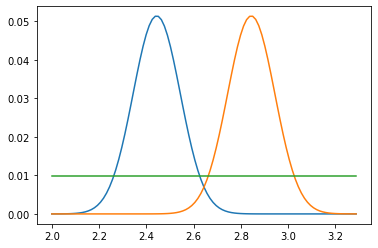

[[294, 246, 352],
 [246, 352, 322],
 [269, 790, 269],
 [790, 660, 603],
 [120, 864, 551],
 [225, 205, 100],
 [1034, 722, 352],
 [864, 722, 722],
 [603, 461, 352],
 [504, 660, 864]]

In [16]:
training_trials, dist_chosen, tone_kind, low_dist, high_dist = task(n_trials = 50, n_tones = 3)

training_trials[0:10]

In [14]:
cnt_low = 0; cnt_high = 0
rows_csv_tr = []
for i_trial in range(len(training_trials)):
    audio, sample_rate = generate_tone_cloud(list(map(int,training_trials[i_trial])))    
    if dist_chosen[i_trial]:
        save_wav(audio, sample_rate, file_name = "soundfiles_three_tones_train_v3/train_wave_low_"\
                 +str(cnt_low)+".wav")
        rows_csv_tr.append(["train_wave_low_"+str(cnt_low)+".wav", 'l', list(map(int,training_trials[i_trial]))])
        cnt_low += 1 
    else:
        save_wav(audio, sample_rate, file_name = "soundfiles_three_tones_train_v3/train_wave_high_"\
                 +str(cnt_high)+".wav")
        rows_csv_tr.append(["train_wave_high_"+str(cnt_high)+".wav", 'h', list(map(int,training_trials[i_trial]))])
        cnt_high += 1         

In [15]:
# field names  
fields = ['Name', 'corrAns', 'Tones','Tonekind']  
    
# name of csv file  
filename = "train_three_tones_v3_file.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)          
    # writing the fields  
    csvwriter.writerow(fields)          
    # writing the data rows  
    csvwriter.writerows(rows_csv_tr) 

In [ ]:
testing_trials, test_dist, test_tone_kind = test_task(n_trials = 60, n_tones = 3)

testing_trials, test_dist, test_tone_kind

In [ ]:
"""Creating the whole testing set beforehand with the random order. Psychopy n_trials = 1"""
s = np.arange(testing_trials.shape[0])
np.random.shuffle(s)
testing_trials_1 = testing_trials[s]; test_dist_1 = test_dist[s]; test_tone_kind_1 = test_tone_kind[s]
np.random.shuffle(s)
testing_trials_2 = testing_trials[s]; test_dist_2 = test_dist[s]; test_tone_kind_2 = test_tone_kind[s]
np.random.shuffle(s)
testing_trials_3 = testing_trials[s]; test_dist_3 = test_dist[s]; test_tone_kind_3 = test_tone_kind[s]

all_testing_trials = np.concatenate((testing_trials,testing_trials_1,testing_trials_2,testing_trials_3))
all_test_dist = np.concatenate((test_dist,test_dist_1,test_dist_2,test_dist_3))
all_test_tone_kind = np.concatenate((test_tone_kind,test_tone_kind_1,test_tone_kind_2,test_tone_kind_3))

In [ ]:
cnt_low = 0; cnt_high = 0
rows_csv_tt = []
for i_trial in range(len(all_testing_trials)):
    audio, sample_rate = generate_tone_cloud(list(map(int,all_testing_trials[i_trial])))    
    if all_test_dist[i_trial]:
        save_wav(audio, sample_rate, file_name = \
                "soundfiles_three_tones_test_v3/test_wave_low_"+str(cnt_low)+".wav")
        rows_csv_tt.append(["test_wave_low_"+str(cnt_low)+".wav",'l',list(map(int,all_testing_trials[i_trial])),\
                           list(map(int,all_test_tone_kind[i_trial]))])
        cnt_low += 1  
    else:
        save_wav(audio, sample_rate, file_name = \
                "soundfiles_three_tones_test_v3/test_wave_high_"+str(cnt_high)+".wav")
        rows_csv_tt.append(["test_wave_high_"+str(cnt_high)+".wav",'h',list(map(int,all_testing_trials[i_trial])),\
                           list(map(int,all_test_tone_kind[i_trial]))])
        cnt_high += 1 

In [ ]:
# field names  
fields = ['Name', 'corrAns', 'Tones', 'Tonekind']  
    
# name of csv file  
filename = "test_three_tones_v3_file.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)          
    # writing the fields  
    csvwriter.writerow(fields)          
    # writing the data rows  
    csvwriter.writerows(rows_csv_tt) 